# <font color=Orange> Fake news Detection </font>
 
 ## **Introduction to Text Classification:** 

 <div style='text-align: justify'> The given problem of detecting fake news from the headlines is basically a text classification problem, which has been addressed using two of the following approaches.</div>
 
>    **Bag-of-words (BoW)**: <br> <sub> <div style='text-align: justify'> Machine learning algorithms are good with numbers and hence we need a way of representing text using numbers. BoW is a way of extracting features from textual data. This basically creates vocabuary of all unique words in the text  which can then be used to train machine learning algorithms. This vocabulary  can then be represented by numbers using various techniques. The two of the most common approaches of representing text using the numbers, this notebook illustrates are: </div>
1. *Frequency of Word:* <br> <div style='text-align: justify'> This approach assumes that if something is repeated again and again in the text then it carries more importance in the given text/document. Hence more the occurence more the importance. Thus, each word is represented by number of occurences of words in the given textual data. <br> For example: The following sentence can be represented as: <br>"In this document this is repeated again again again, and now again, in this document ". this sentence can be represented as : <br > </div>
>
> ```python
 vect = {"in":2,"this":3,"document:"2, "is":1, "repeated":1, "again":4, "now":1, }
  ```
2. *Term frequency*- Inverse document frequency (TF-IDF):<br><div style='text-align: justify'> With TF-IDF it is assumed that more quency words carry less information and less frequency/peculiar word gives more information gain in the document. Specifically, in TF-IDF more weight is given to the word which occurs more frequently in current document and low in any other document in the training corpus. Mathematically:</div>
>
> <div style='text-align: center'><img src="https://latex.codecogs.com/svg.latex?\Large&space;w_{x,y}=tf_{x,y} \times log (\frac  {N}{df_{x,y}})"></div>
><div style='text-align: center'><img src="https://latex.codecogs.com/svg.latex?\Large&space;Where,\\ w_{x,y}= \ weight \ of \ word \ x \ in \ document \ y \\ tf_{x,y}= \ frequency \ of \ x \ in \ y \\ N = \ total \ number \ of  \ documents"></div>
>
> **Word Embeddings**:<br> <div style='text-align: justify'>If words with similar meaning have similar representation then a vector representing a word can be more dense than sparse as compared to their representation in case of *bag-of-words*. Word embedding allows similar words to have similar representation. This means that individual words have to be defined by a vector. These vectors are learned from a text corpus which helps a classifier in understanding the relationship of a word with its neighbouring word. To learn this vector representation of text we can learn this by adding an embedding layer in the neural network or use *word2vec* to find this representaion before using them in the neural network. <br> 
1. *Word2Vec:* <br>This is a shallow neural network used to learn word embeddings. By training such a small neural network on large corpus of documents, we get a good representation of words which can then be used for any text classification task. This approach is particularly useful because similar words are represented by similar vectors in the vectorspace. Given enough word corpus, *word2vec* can learn word associations e.g. "King" is to "Queen" what "boy" is to "girl". The main optimisation goal here is to lower the cosine similarity of similar words.</div>






In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import stop_words
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from matplotlib import cm
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import nltk
nltk.download('stopwords')
plt.style.use('default')
import warnings
warnings.simplefilter(action='ignore', category=[FutureWarning, ConvergenceWarning])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#  <font color= "Blue" > The Dataset </font>
The given dataset is a .json file containing labeled headlines of the news which are to be classified as fake or real. This clearly is a text classification problem and hence this notebook uses the two apporaches mentioned above for this classification task. 

In this case python library *pandas* is used to read the json file and convert the dataset to *Dataframe* which is the native structure of the *pandas*.


In [0]:
#import given json file
df = pd.read_json("/content/drive/My Drive/fake_news.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


# <font color= "Blue" > Preprocessing: </font> <br>

<div style='text-align: justify'>The first step in any machine learning problem is to perform preprocessing to the given data and grab insights from the data so that they can be fed intuitively to appropriate machine learning algorithms.</div>

Below are the some of the preprocessing steps taken:

1. <div style='text-align: justify'> Find unique charachters in the dataset and remove any punctuation marks, numbers which are present in the "headline" . This step is done because these charachters/numbers doesnot add weight to any contextual information present in the given data.</div>


2. <div style='text-align: justify'>Shuffle the data so as to remove any skewness in the data while doing the train-test split i.e preventing the presence of more examples of one class than other excessively in one split than other. </div>

3. <div style='text-align: justify'> Remove any duplicate entries in the dataset. </div>

4. <div style='text-align: justify'>Perform the train-validation-test split and save the split in named files. </div>



### Step 1: Remove punctuation/numbers/alphanumerical charachters

In [0]:
#Step 1: Remove the punctuation/numbers/alphanumnerical charachters
# function to remove any punctuation, symbols, numbers. 

def cleantxt(txt):
  txt = txt.lower()
  #remove punctuation
  txt = re.sub(r'[/(){}\[\]\|@,;]',' ',txt)
  #remove bad words
  txt = re.sub(r'[^0-9a-z #+_]','', txt)
  txt = re.sub(r'#','', txt);
  #remove numbers
  txt = re.sub(r'\d+','',txt)
  return txt

df['headline'] = df.headline.apply(cleantxt)

### Step 2 & 3: Shuffle the dataset and Remove Duplicate entries:


In [0]:
#Shuffle dataset
df = df.sample(frac = 1).reset_index(drop=True);

#Remove the "Article link column"
df_clean = pd.concat([df['headline'], df['is_sarcastic']], axis =1)
print("Number of entries before removing duplicates \n", df_clean.count())

#print the duplicate entries count
dup_count  = df_clean[df_clean.duplicated()].count()
print("Duplicate Entries:: \n",dup_count)
type(dup_count[0])
#if there are duplicate enties, remove them
if dup_count[0]!=0:
  df_clean = df_clean.drop_duplicates()
  print("NUmber of entries after removing duplicates: \n", df_clean.count())

Number of entries before removing duplicates 
 headline        28619
is_sarcastic    28619
dtype: int64
Duplicate Entries:: 
 headline        141
is_sarcastic    141
dtype: int64
NUmber of entries after removing duplicates: 
 headline        28478
is_sarcastic    28478
dtype: int64


### Step 4: Split the data into train, validation and test set and store them in the file.

Note: In this Notebook, *df_valid* is used as testing set and *df_test* as validation set


In [0]:
X = df_clean.headline
Y = df_clean.is_sarcastic

df_train, df_test = train_test_split(df_clean, test_size = 0.15, random_state=23)
df_valid, df_test = train_test_split(df_test, test_size = 0.50, random_state=23)

print("Training data size", df_train['headline'].shape,
      df_train['is_sarcastic'].shape);
print("Validation data size", df_valid['headline'].shape,
      df_valid['is_sarcastic'].shape)
print("Testing data size", df_test['headline'].shape, 
      df_test['is_sarcastic'].shape)

Training data size (24206,) (24206,)
Validation data size (2136,) (2136,)
Testing data size (2136,) (2136,)


### Save Dataframes in CSV files

In [0]:
df_train.to_csv('/content/drive/My Drive/Fake_news_detect_op/train.csv')
df_valid.to_csv('/content/drive/My Drive/Fake_news_detect_op/test.csv')
df_test.to_csv('/content/drive/My Drive/Fake_news_detect_op/validation.csv')

### Visualizing data in different splits

The output of this step show that spliting of the data is done fairly well and there is no major skewness in any of the split. 

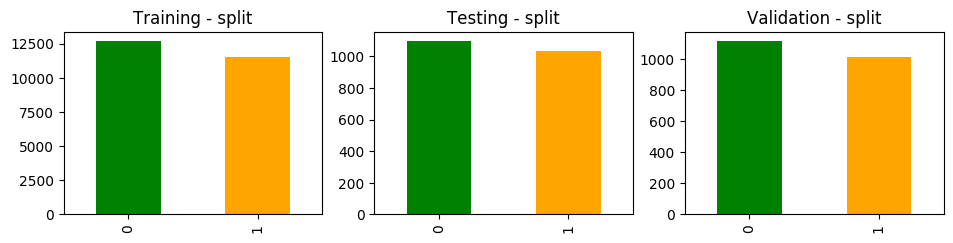

In [0]:
fig,ax = plt.subplots(1,3)
plt.subplots_adjust(bottom = 0.5,right = 1.5, wspace = 0.2)
plt.subplot(1,3,1)
df_train['is_sarcastic'].value_counts()[:].plot(kind='bar', color=['green','orange']);
plt.title("Training - split")

plt.subplot(1,3,2)
df_test['is_sarcastic'].value_counts()[:].plot(kind='bar', color=['green','orange']);
plt.title("Testing - split")

plt.subplot(1,3,3)
df_valid['is_sarcastic'].value_counts()[:].plot(kind='bar', color=['green','orange']);
plt.title("Validation - split");

# <font color= "Blue" > Feature Extraction using Bag of Words (BoW) </font>

As mentioned above, there are two ways which can be used to represent the textual information with numbers in BoW.
1. Frequency of words: <br> Scikit learn's *sklearn.feature_extraction* module provided *CountVectorizer* function builds matrix of numbers from the text based on the frequency of word in the text. The output shows the frequency of the words in the headlines (all combined). Here number of rows represent all unique words in the training data and number of columns represents number of training examples. The number in each row defines the frequency of the word in the current headline.
2. Term Frequency -Inverse Document Frequency: <br> Scikit learn's *sklearn.feature_extraction* module provided *TfidfVectorizer* function lets us to build matrix of numbers from the text based on uniqueness of the word in the current document relative to rest of the documents under observation. Here rows and columns number have save meaning as in *CountVectorizer*, although the number in each row gives the calculated weight of each word in the current headline calculated using the formula stated above and can be interpreted accordingly.

This can beimplemented as below





In [0]:
cnt_vect = CountVectorizer()
cnt_vect_fit = cnt_vect.fit_transform(df_train['headline'])
print("Shape of the CountVectoriser representation: ", 
      cnt_vect_fit.toarray().shape)
print("Unique values in the CountVectoriser: ", 
      np.unique(cnt_vect_fit.toarray()))

tfidf_vect = TfidfVectorizer(min_df=1)
tfidf_vect_fit = tfidf_vect.fit_transform(df_train['headline'])
print("Shape of the TfidfVectoriser representation: ", 
      tfidf_vect_fit.toarray().shape)
print("Unique values in the TfidfVectoriser: ", 
      np.unique(tfidf_vect_fit.toarray()))


Shape of the CountVectoriser representation:  (24206, 26596)
Unique values in the CountVectoriser:  [0 1 2 3 4 5 7 8]
Shape of the TfidfVectoriser representation:  (24206, 26596)
Unique values in the TfidfVectoriser:  [0.         0.02575169 0.03080617 ... 0.94834091 0.94948511 1.        ]


# <font color= "Blue" > Data analysis and Model Selection. </font>

## implementPipeline()

This Function lets build the pipeline to train a classifier and gives accuracy score on testing dataset, classification report and roc curve.

In [0]:
def implementPipeline( vect, classifier_obj, Xtrain, Ytrain, Xtest, Ytest, Xvalid, Yvalid,name, if_accuracy=False,if_report = False, plot_roc= False):
  pipe = Pipeline([('vect', vect),
                #'vect', CountVectorizer()),
               ('clf', classifier_obj),
              ])
  Ytrain = Ytrain.astype('int')
  pipe.fit(Xtrain, Ytrain)
  probab = pipe.predict_proba(Xtest)
  probab = probab[:, 1]
  Ypred = pipe.predict(Xtest)
  Ypred_train = pipe.predict(Xtrain)
  Ycv = pipe.predict(Xvalid)

  labels=['real', 'fake']

  Ytest = Ytest.astype('int')
  Yvalid = Yvalid.astype('int')
  if if_accuracy==True:
    print('accuracy test %s' % (accuracy_score(Ypred, Ytest)*100))
    print('accuracy train %s' % (accuracy_score(Ypred_train, Ytrain)*100))
    print('accuracy Validation %s' % (accuracy_score(Ycv, Yvalid)*100))
  if if_report==True:
    print("Classification Report on Test Set \n",classification_report(Ytest, Ypred,target_names=labels))
    print('Confusion Matrix: \n', confusion_matrix(Ytest, Ypred))
  
  if plot_roc == True:
    fpr, tpr, _ = roc_curve(Ytest, probab)
    auc = roc_auc_score(Ytest, probab)
    #plt.figure()
    plt.plot(fpr, tpr, marker='.',color='darkorange', label='%s (area = %0.2f)' % (name,auc))
    #plt.text(25,5, classification_report(Ytest, Ypred,target_names=labels))
    plt.plot([0, 1], [0, 1], linestyle='--',color='navy', label='No learning')
    plt.legend(loc="lower right")
    plt.title(name+' model' +'\n accuracy test %s' % round(accuracy_score(Ypred, Ytest)*100,3) + ' \n accuracy train %s' % round(accuracy_score(Ypred_train, Ytrain)*100,3) + '\n accuracy Validation %s' % round(accuracy_score(Ycv, Yvalid)*100,3)+ '\n'+'-'*80+'\n'+ classification_report(Ytest, Ypred,target_names=labels),fontsize=8)
    #plt.show()

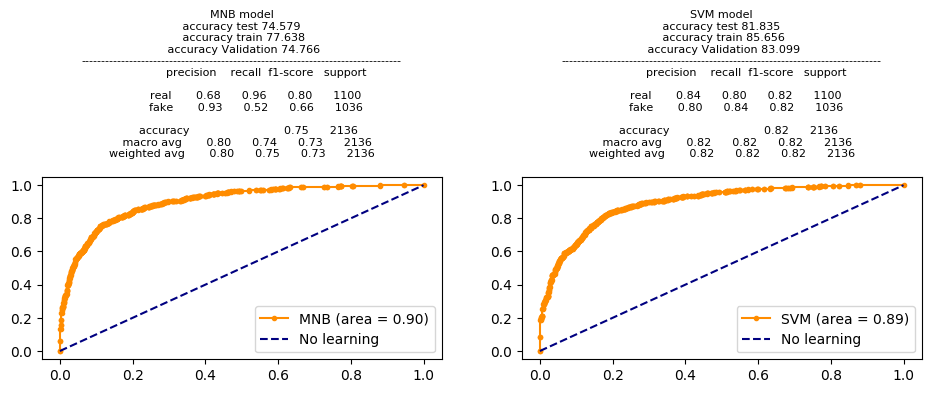

In [0]:
fig,ax = plt.subplots(1,2)
plt.subplots_adjust(bottom = 0.5,right = 1.5, wspace = 0.2)
plt.subplot(1,2,1)
implementPipeline( TfidfVectorizer(min_df =1, ), MultinomialNB(alpha=30), df_train['headline'], df_train['is_sarcastic'], df_test['headline'], df_test['is_sarcastic'], df_valid['headline'], df_valid['is_sarcastic'], name ='MNB', plot_roc=True)

from sklearn.linear_model import SGDClassifier
plt.subplot(1,2,2)
implementPipeline( TfidfVectorizer(min_df =1, ), SGDClassifier(loss='log',alpha = 0.25*1e-3), df_train['headline'], df_train['is_sarcastic'], df_test['headline'], df_test['is_sarcastic'], df_valid['headline'], df_valid['is_sarcastic'], name= 'SVM', plot_roc=True)

## 1. Presence of stop words: <br>

First, by ploting the top twenty words occuring in fake and real news headline, it is observed that the most frequent words are the stop-words like "to", "of" ,"the", etc. These words donot lead to any information gain and is a major contributer when a classification model overfits the textual information.<br> 
To demonstrate this a simple multinomial naive bayes model is built using *CountVectorizer*. <br>
Note: Here TF-TDF vectorizer is not used because inherently it will assign lower weight to stop words which can lower the effect of the presence of stop words.

In [0]:
#function to remove stopwords:
def remove_stopword(txt):
  txt = ' '.join(word for word in txt.split() if word not in stop_words.ENGLISH_STOP_WORDS)
  return txt

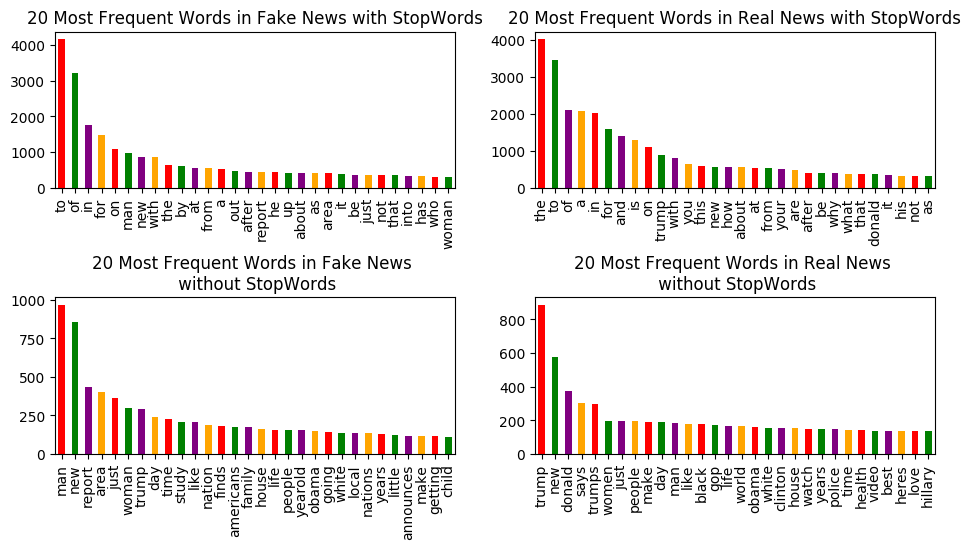

In [0]:
## PLot 20 high frequency words with and without stop words
fig,ax = plt.subplots(2,2)
plt.subplots_adjust(bottom = 0,right = 1.5, wspace = 0.2, hspace = 0.7)
plt.subplot(2,2,1)
fake_words = df_train.loc[df_train['is_sarcastic']==1]['headline']
fake_words = pd.Series(" ".join(fake_words).split())
fake_words.value_counts()[0:30].plot(kind='bar',
      color=['r','g','purple','orange'])#, colormap= cm.get_cmap('summer'));
plt.title("20 Most Frequent Words in Fake News with StopWords")

plt.subplot(2,2,2)
true_words = df_train.loc[df_train['is_sarcastic']==0]['headline']
true_words = pd.Series(" ".join(true_words).split())
true_words.value_counts()[0:30].plot(kind='bar', color=['r','g','purple','orange']);
plt.title("20 Most Frequent Words in Real News with StopWords")

temp_train = df_train.copy() 
temp_train['headline'] =df_train.headline.apply(remove_stopword) 

plt.subplot(2,2,3)
fake_words = temp_train.loc[temp_train['is_sarcastic']==1]['headline']
fake_words = pd.Series(" ".join(fake_words).split())
fake_words.value_counts()[0:30].plot(kind='bar',
          color=['r','g','purple','orange'])#, colormap= cm.get_cmap('summer'));
plt.title("20 Most Frequent Words in Fake News \n without StopWords")

plt.subplot(2,2,4)
true_words = temp_train.loc[temp_train['is_sarcastic']==0]['headline']
true_words = pd.Series(" ".join(true_words).split())
true_words.value_counts()[0:30].plot(kind='bar', color=['r','g','purple','orange']);
plt.title("20 Most Frequent Words in Real News \n without StopWords");

In [0]:
#Multinomial NB with stopwords
implementPipeline( CountVectorizer(), MultinomialNB(),
                  df_train['headline'], df_train['is_sarcastic'],
                  df_test['headline'], df_test['is_sarcastic'],
                  df_valid['headline'], df_valid['is_sarcastic'],
                  name ='MNB', if_accuracy=True)

accuracy test 84.12921348314607
accuracy train 93.36941254234488
accuracy Validation 85.25280898876404


As seen from the above accuracy score, there is a huge gap between training and validation/testing accuracy in presence of stop_word.  The following code implements *CountVectorizer* with argument *stop_words='english'* thus removing the stop_words when text will be tokenized.

In [0]:
#Multinomial NB without stopwords
implementPipeline( CountVectorizer(stop_words='english'), MultinomialNB(), 
                  df_train['headline'], df_train['is_sarcastic'], 
                  df_test['headline'], df_test['is_sarcastic'], 
                  df_valid['headline'], df_valid['is_sarcastic'], 
                  name ='MNB', if_accuracy=True)


accuracy test 79.54119850187266
accuracy train 91.64256795835743
accuracy Validation 80.6179775280899


As seen from the above accuracy score the training accuracy has been penalised a little bit but still difference in testing and training accuracy is huge and the model is still overfitting the curve.

Lets try with different models and see if the overfitting still exist



In [0]:
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
#SettingWithCopyWarning
#warnings.filterwarnings("ignore", category=com.SettingWithCopyWarning)

In [0]:
# SVM without count without stopwords
print("SVM model scores:")
implementPipeline( CountVectorizer(stop_words='english'), 
                  SGDClassifier(loss='log'), df_train['headline'], 
                  df_train['is_sarcastic'], df_test['headline'], 
                  df_test['is_sarcastic'], df_valid['headline'], 
                  df_valid['is_sarcastic'], name ='MNB', if_accuracy=True)

# Logistic regression without stopwords
print("\nLogistic regression model scores:")
implementPipeline( CountVectorizer(stop_words='english'), 
                  LogisticRegression(solver ='lbfgs',max_iter=100), 
                  df_train['headline'], df_train['is_sarcastic'], 
                  df_test['headline'], df_test['is_sarcastic'], 
                  df_valid['headline'], df_valid['is_sarcastic'], 
                  name ='MNB', if_accuracy=True)


SVM model scores:
accuracy test 78.41760299625467
accuracy train 91.82434107246137
accuracy Validation 80.4307116104869

Logistic regression model scores:
accuracy test 79.16666666666666
accuracy train 94.92687763364455
accuracy Validation 79.82209737827716


As seen form the above scores, first from SVM classifier and then from Logistic regression,<font color= "Blue" > the overfitting still exists </font>



## 2. Hyper-Parameter Tuning (Manual): <br>

In this section, we adjust the parameters for various classifiers to overcome overfitting. The basic approach here is to tune parameters specific to classifiers that tend to penalize the classifier and prevent training data memorization. This process is mainly done manually by plugging various values of hyperparameters of different classifiers. Some of the basic parameters that needs to be modified to overcome overfitting are:
* Increase regularization in case of Logistic Regression, SVM classifier.
* Increase laplace smoothening parameter in case of Multinomial Naive Bayes.
* Limit tree depth in case of Decision Tree classifier to decrease variance.
* Adjust number of estimators in case of Random forest classifier.<br>
etc.

After trying various values for above mentioned hyperparamenters below are the optimized hyperparameter values:

- For Multinomial NB: alpha = 30
- For SVM/SGDClassifier: Regularization paramenter, alpha = 2*1e-3
- For Logistic Regression: Regularization parameter, C = 0.5
- For Decision Tree: maximum tree depth, max_depth = 30
- For Random Forest : number of estimators = 30 and maximum depth = 50


Note: For SVM and Logistic regression, regularization paramenter is actually the inverse regularization parameter, i.e smaller the value stronger the regularization




In [0]:
print('After parameter optimization:')
print("\n ************MultinomialNB model scores:***************")
implementPipeline( CountVectorizer(stop_words='english'), MultinomialNB(alpha=30), 
                  df_train['headline'], df_train['is_sarcastic'], 
                  df_test['headline'], df_test['is_sarcastic'], 
                  df_valid['headline'], df_valid['is_sarcastic'], 
                  name ='MNB', if_accuracy=True)

print("\n ****************SVM model scores:********************")
implementPipeline( CountVectorizer(stop_words='english'), SGDClassifier(loss='log',alpha = 2*1e-3), 
                  df_train['headline'], df_train['is_sarcastic'], 
                  df_test['headline'], df_test['is_sarcastic'], 
                  df_valid['headline'], df_valid['is_sarcastic'], 
                  name ='MNB', if_accuracy=True)

print("\n*****************Logistic Regression model scores:****************")
implementPipeline( CountVectorizer(stop_words='english'), LogisticRegression(penalty='l1', max_iter=100, C=0.5), 
                  df_train['headline'], df_train['is_sarcastic'], 
                  df_test['headline'], df_test['is_sarcastic'], 
                  df_valid['headline'], df_valid['is_sarcastic'], 
                  name ='MNB', if_accuracy=True)

print("\n*****************Decision Tree Classifier model scores:**************")
implementPipeline( CountVectorizer(stop_words='english'), DecisionTreeClassifier(max_depth = 30,random_state=1), 
                  df_train['headline'], df_train['is_sarcastic'], 
                  df_test['headline'], df_test['is_sarcastic'], 
                  df_valid['headline'], df_valid['is_sarcastic'], 
                  name ='MNB', if_accuracy=True)

print("\n *****************RandomForest model scores:******************")
implementPipeline( CountVectorizer(stop_words='english'), RandomForestClassifier(n_estimators= 30,max_depth = 50,random_state=0), 
                  df_train['headline'], df_train['is_sarcastic'], 
                  df_test['headline'], df_test['is_sarcastic'], 
                  df_valid['headline'], df_valid['is_sarcastic'], 
                  name ='MNB', if_accuracy=True)

After parameter optimization:

 ************MultinomialNB model scores:***************
accuracy test 76.87265917602997
accuracy train 82.90093365281335
accuracy Validation 79.07303370786516

 ****************SVM model scores:********************
accuracy test 72.3314606741573
accuracy train 77.91456663637115
accuracy Validation 75.88951310861424

*****************Logistic Regression model scores:****************
accuracy test 76.17041198501873
accuracy train 82.83896554573246
accuracy Validation 77.62172284644194

*****************Decision Tree Classifier model scores:**************
accuracy test 64.09176029962546
accuracy train 67.78484673221516
accuracy Validation 64.32584269662921

 *****************RandomForest model scores:******************
accuracy test 68.25842696629213
accuracy train 76.77435346608279
accuracy Validation 70.78651685393258


As seen from the above score, although the accuracy scores are not high, <font color="Blue">hyper-parameter tuning has certainly helped lower the overfitting in the models</font>  

## 3. Experiment with Vectorizer
In previous sections, *CountVectorizer* was used. Since the frequency of words donot necessarily provide information gain, we can use *TfidfVectoriser* and achieve better accuracy score. Below output certainly shows some improvement is overall accuracy score. 

<font color="Blue"> Important Observation:</font> For this particular dataset *TfidfVectorizer* gives comparatively higher accuracy when stopwords are not removed


In [0]:
print('Using Optimized hyper-parameters with TfifdVectorizer :')
print("\n ************MultinomialNB model scores:***************")
implementPipeline( TfidfVectorizer(min_df=1), MultinomialNB(alpha=10), 
                  df_train['headline'], df_train['is_sarcastic'], 
                  df_test['headline'], df_test['is_sarcastic'], 
                  df_valid['headline'], df_valid['is_sarcastic'], 
                  name ='MNB', if_accuracy=True)

print("\n ****************SVM model scores:********************")
implementPipeline( TfidfVectorizer(min_df=1), SGDClassifier(loss='log',alpha = 0.25*1e-3), 
                  df_train['headline'], df_train['is_sarcastic'], 
                  df_test['headline'], df_test['is_sarcastic'], 
                  df_valid['headline'], df_valid['is_sarcastic'], 
                  name ='MNB', if_accuracy=True)

print("\n*****************Logistic Regression model scores:****************")
implementPipeline( TfidfVectorizer(min_df=1), LogisticRegression(penalty='l1', max_iter=100, C=0.5), 
                  df_train['headline'], df_train['is_sarcastic'], 
                  df_test['headline'], df_test['is_sarcastic'], 
                  df_valid['headline'], df_valid['is_sarcastic'], 
                  name ='MNB', if_accuracy=True)

print("\n*****************Decision Tree Classifier model scores:**************")
implementPipeline( TfidfVectorizer(min_df=1), DecisionTreeClassifier(max_depth = 30,random_state=1), 
                  df_train['headline'], df_train['is_sarcastic'], 
                  df_test['headline'], df_test['is_sarcastic'], 
                  df_valid['headline'], df_valid['is_sarcastic'], 
                  name ='MNB', if_accuracy=True)

print("\n *****************RandomForest model scores:******************")
implementPipeline( TfidfVectorizer(min_df=1), RandomForestClassifier(n_estimators= 30,max_depth = 35,random_state=0), 
                  df_train['headline'], df_train['is_sarcastic'], 
                  df_test['headline'], df_test['is_sarcastic'], 
                  df_valid['headline'], df_valid['is_sarcastic'], 
                  name ='MNB', if_accuracy=True)

Using Optimized hyper-parameters with TfifdVectorizer :

 ************MultinomialNB model scores:***************
accuracy test 79.44756554307116
accuracy train 84.85912583656945
accuracy Validation 80.80524344569288

 ****************SVM model scores:********************
accuracy test 81.78838951310861
accuracy train 85.63579277864991
accuracy Validation 83.19288389513109

*****************Logistic Regression model scores:****************
accuracy test 77.99625468164794
accuracy train 81.83921341816078
accuracy Validation 81.32022471910112

*****************Decision Tree Classifier model scores:**************
accuracy test 72.98689138576779
accuracy train 80.343716433942
accuracy Validation 73.97003745318352

 *****************RandomForest model scores:******************
accuracy test 76.26404494382022
accuracy train 83.66933818061638
accuracy Validation 76.87265917602997


## 4. Selecting Maximum Number of Features:

It can be observed from the data that major problem here is overfitting. So another approach  to penalize classifier is limiting number of features. In this way classifier has less features to work with and hence makes the training split more dense. 

Now the next question is how do we choose this paramenter?<br>
This question can be addressed by finding average size of the headlines in fake and real news. Below code plots the box plot of length of the headlines by adding an extra feature to the training dataframe i.e. _"news_len"_.


In [0]:
df_train['news_len'] = [len(line) for line in df_train.headline]



In [0]:
df_train.head()

,headline,is_sarcastic,news_len
5046,all the sleepy hollow season intel you can ha...,0,50
20215,anonymous source informs bob woodward he hasnt...,1,70
18383,jennifer lopezs new video is a sad premonition...,0,72
22775,suzanne somers named us thighmaster general,1,43
15038,the brawny man is the brawny woman for womens ...,0,59


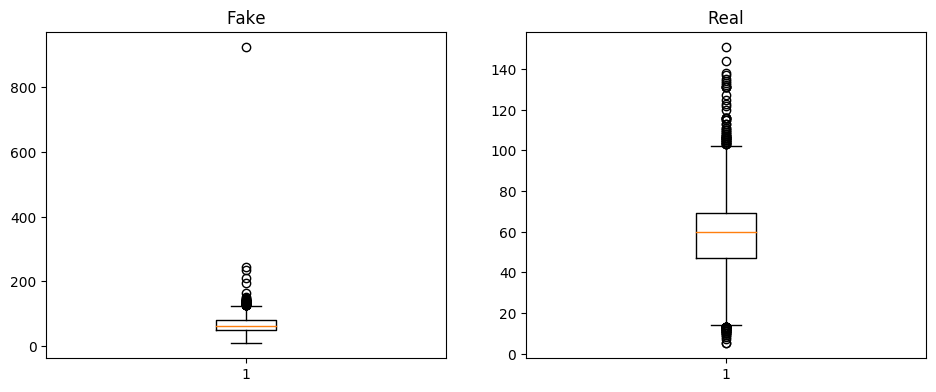

In [0]:
fig,ax = plt.subplots(1,2)
plt.subplots_adjust(bottom = 0.2,right = 1.5, wspace = 0.2, hspace = 0.7)
plt.subplot(1,2,1)
plt.boxplot(df_train.news_len[df_train.is_sarcastic == 1])
plt.title('Fake')

plt.subplot(1,2,2)
plt.boxplot(df_train.news_len[df_train.is_sarcastic == 0])         
plt.title('Real');

It can be easily observed that there's a <font color="blue">huge outlier with more than 800 charachter length </font> and on an average, the news length lies around 60 charachter. Here max charachter length of 250 is selected which is approximately equal to the second highest value of headline length and model has been fit on this width of the vectorizer.


In [0]:
print('Using Optimized hyper-parameters with TfifdVectorizer and max_features :')
print("\n ************MultinomialNB model scores:***************")
m_x = 250
implementPipeline( TfidfVectorizer(min_df=1, max_features=m_x), MultinomialNB(alpha=5), 
                  df_train['headline'], df_train['is_sarcastic'], 
                  df_test['headline'], df_test['is_sarcastic'], 
                  df_valid['headline'], df_valid['is_sarcastic'], 
                  name ='MNB', if_accuracy=True)

print("\n ****************SVM model scores:********************")
implementPipeline( TfidfVectorizer(min_df=1, max_features=m_x), SGDClassifier(loss='log',alpha = 0.25*1e-2), 
                  df_train['headline'], df_train['is_sarcastic'], 
                  df_test['headline'], df_test['is_sarcastic'], 
                  df_valid['headline'], df_valid['is_sarcastic'], 
                  name ='MNB', if_accuracy=True)

print("\n*****************Logistic Regression model scores:****************")
implementPipeline( TfidfVectorizer(min_df=1, max_features=m_x), LogisticRegression(penalty='l1', max_iter=100, C=0.5), 
                  df_train['headline'], df_train['is_sarcastic'], 
                  df_test['headline'], df_test['is_sarcastic'], 
                  df_valid['headline'], df_valid['is_sarcastic'], 
                  name ='MNB', if_accuracy=True)

print("\n*****************Decision Tree Classifier model scores:**************")
implementPipeline( TfidfVectorizer(min_df=1, max_features=m_x), DecisionTreeClassifier(max_depth = 30,random_state=1), 
                  df_train['headline'], df_train['is_sarcastic'], 
                  df_test['headline'], df_test['is_sarcastic'], 
                  df_valid['headline'], df_valid['is_sarcastic'], 
                  name ='MNB', if_accuracy=True)

print("\n *****************RandomForest model scores:******************")
implementPipeline( TfidfVectorizer(min_df=1, max_features=m_x), RandomForestClassifier(n_estimators= 40,max_depth = 35,random_state=0), 
                  df_train['headline'], df_train['is_sarcastic'], 
                  df_test['headline'], df_test['is_sarcastic'], 
                  df_valid['headline'], df_valid['is_sarcastic'], 
                  name ='MNB', if_accuracy=True)

Using Optimized hyper-parameters with TfifdVectorizer and max_features :

 ************MultinomialNB model scores:***************
accuracy test 75.56179775280899
accuracy train 75.3903990746096
accuracy Validation 76.63857677902621

 ****************SVM model scores:********************
accuracy test 75.32771535580525
accuracy train 75.29951251755763
accuracy Validation 77.34082397003745

*****************Logistic Regression model scores:****************
accuracy test 76.68539325842697
accuracy train 77.1255060728745
accuracy Validation 77.43445692883894

*****************Decision Tree Classifier model scores:**************
accuracy test 71.44194756554307
accuracy train 78.84821944972322
accuracy Validation 72.00374531835206

 *****************RandomForest model scores:******************
accuracy test 75.09363295880149
accuracy train 81.67809633975047
accuracy Validation 75.56179775280899


It can be easily observed from the above accuracy scores that although the accuracy value is lower,<font color='blue'> model is not overfitting for MultinomialNB, SVM and Logistic Regression</font> 

Based on this observation, these three models will be analysed further to do model selection

## 5. Hyper-Paramenter Tuning using Grid Search Cross-validation: <br>

One of the most commom approach used for training machin learning algorithm is *Cross-validation*.
Sickit learn library provides a way to fine tune the hyperparameters using N-fold Cross Validation Approach. In this approach basically the training data is subdivided divided into training and validation split internally and then at every step of training, they are optimised for the range of values of hyperparameters given. This is a exhaustive approach to find best hyperparameter with specified estimator/classifier. This approach of training is particularly effective because the classifier is trained k different times on different train-test split and hence contains very less bais. This approach is particularly useful when data is limited.

In this case 10-fold cross-validation is used to find best parameters. Below are the results of GridSearchCV on MultinomialNB, SVM and Logistic regression. 

In [0]:
dep =np.arange(1,10,0.5)
param_grid = {'alpha':dep}
#param_grid = {'loss':loss_va}

mnb = MultinomialNB()
mnb_cv = GridSearchCV(mnb, param_grid = param_grid, cv=10)
mnb_cv.fit(tfidf_vect_fit,df_train['is_sarcastic'])
xt = tfidf_vect.transform(df_test['headline'])
pred_t =  mnb_cv.predict(xt)
print ("Tuned MultinomialNB paramenter: ", format(mnb_cv.best_params_))

print ("Best Score is: ", format(mnb_cv.best_score_))
print("test acc: ", accuracy_score(df_test['is_sarcastic'],pred_t))


Tuned MultinomialNB paramenter:  {'alpha': 1.0}
Best Score is:  0.8317772453110799
test acc:  0.8216292134831461


In [0]:
dep =np.arange(1e-5,1e-2,1e-3)
loss_va = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
param_grid = {'alpha':dep, 'loss':loss_va }
#param_grid = {'loss':loss_va}

svm = SGDClassifier()
svm_cv = GridSearchCV(svm, param_grid = param_grid, cv=10)
svm_cv.fit(tfidf_vect_fit,df_train['is_sarcastic'])
xt = tfidf_vect.transform(df_test['headline'])
pred_t =  svm_cv.predict(xt)
print ("Tuned SVM paramenter: ", format(svm_cv.best_params_))

print ("Best Score is: ", format(svm_cv.best_score_))
print("test acc: ", accuracy_score(df_test['is_sarcastic'],pred_t))

Tuned SVM paramenter:  {'alpha': 1e-05, 'loss': 'log'}
Best Score is:  0.8443361150128067
test acc:  0.8384831460674157


In [0]:
dep =np.arange(1,20,0.1)
ite =np.arange(100,500,100)
reg = ['l1', 'l2']
#param_grid = {'alpha':dep}
#param_grid = {'penalty':reg, 'C':dep, 'max_iter':ite}
param_grid = {'C':dep}

LG = LogisticRegression(max_iter= 100)
LG_cv = GridSearchCV(LG, param_grid = param_grid, cv=10)
LG_cv.fit(tfidf_vect_fit,df_train['is_sarcastic'])
xt = tfidf_vect.transform(df_test['headline'])
pred_t =  LG_cv.predict(xt)
print ("Tuned Logistic Regression paramenter: ", format(LG_cv.best_params_))

print ("Best Score is: ", format(LG_cv.best_score_))
print("test acc: ", accuracy_score(df_test['is_sarcastic'],pred_t))

Tuned Logistic Regression paramenter:  {'C': 3.300000000000002}
Best Score is:  0.8459885978682972
test acc:  0.8408239700374532


It can be observed that the overall accuracy of all the models has improved significantly. Thus Cross-validation is an effective way of generalizing classifiers on training data.

# <font color="Blue">Model Selection</font>


## ROC Curve and AUC

Reciever Operating Characteristic (ROC) Curve gives a measure of performance of the classification model in terms True Positive Rate (aka recall) (TPR) and False Positive Rate (FPR). The ROC curve is basically a TPR vs FPR plot, where lower calssification threshold values results in classifier detecting more examples as positive.

<img src="https://developers.google.com/machine-learning/crash-course/images/ROCCurve.svg" alt="drawing" width="300"/>

Area under curve basically defines the performance of models irrespective of the classification threshold. For poorly trained classifier AUC tends to be equal to 0.0 , whereas a good classfier results in value close to 1.0.

<img src="https://developers.google.com/machine-learning/crash-course/images/AUC.svg" alt="drawing" width="300"/>

Lets Find the ROC curve of the trained classifier based on the Testing data.

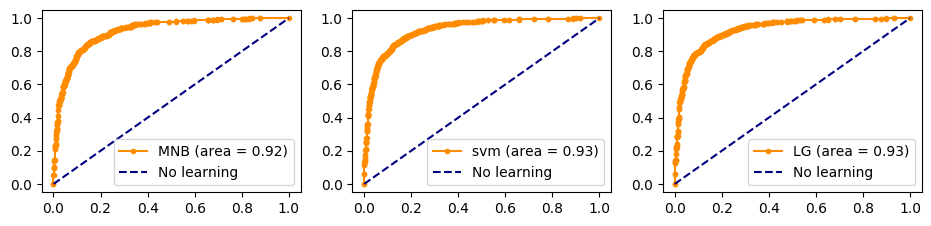

In [0]:
fig,ax = plt.subplots(1,3)
plt.subplots_adjust(bottom = 0.5,right = 1.5, wspace = 0.2, hspace = 0.7)

prob_mnb = mnb_cv.predict_proba(tfidf_vect.transform(df_valid['headline']))
probab_mnb = prob_mnb[:, 1]
fpr_mnb, tpr_mnb, _ = roc_curve(df_valid['is_sarcastic'], probab_mnb)
auc_mnb = roc_auc_score(df_valid['is_sarcastic'], probab_mnb)

plt.subplot(1,3,1)
plt.plot(fpr_mnb, tpr_mnb, marker='.',color='darkorange', label='%s (area = %0.2f)' % ('MNB',auc_mnb))
plt.plot([0, 1], [0, 1], linestyle='--',color='navy', label='No learning')
plt.legend(loc="lower right")

prob_svm = svm_cv.predict_proba(tfidf_vect.transform(df_valid['headline']))
probab_svm = prob_svm[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(df_valid['is_sarcastic'], probab_svm)
auc_svm = roc_auc_score(df_valid['is_sarcastic'], probab_svm)

plt.subplot(1,3,2)
plt.plot(fpr_svm, tpr_svm, marker='.',color='darkorange', label='%s (area = %0.2f)' % ('svm',auc_svm))
plt.plot([0, 1], [0, 1], linestyle='--',color='navy', label='No learning')
plt.legend(loc="lower right")

prob_LG = LG_cv.predict_proba(tfidf_vect.transform(df_valid['headline']))
probab_LG = prob_LG[:, 1]
fpr_LG, tpr_LG, _ = roc_curve(df_valid['is_sarcastic'], probab_LG)
auc_LG = roc_auc_score(df_valid['is_sarcastic'], probab_LG)

plt.subplot(1,3,3)
plt.plot(fpr_LG, tpr_LG, marker='.',color='darkorange', label='%s (area = %0.2f)' % ('LG',auc_LG))
plt.plot([0, 1], [0, 1], linestyle='--',color='navy', label='No learning')
plt.legend(loc="lower right");

As seen from above ROC curves and AUC , all the chosen classifiers perform equally well on the testing data. Lets plot the confusion matrix for all the classifiers now.

In [0]:
from sklearn.metrics import confusion_matrix

labels = ['real', 'fake']
cm = confusion_matrix(df_valid['is_sarcastic'], mnb_cv.predict(tfidf_vect.transform(df_valid['headline'])))
print( "CM for MNB:\n",cm)
print("Classification Report on Test Set For MNB \n",classification_report(df_valid['is_sarcastic'], mnb_cv.predict(tfidf_vect.transform(df_valid['headline'])),target_names=labels))

cm = confusion_matrix(df_valid['is_sarcastic'], svm_cv.predict(tfidf_vect.transform(df_valid['headline'])))
print( "CM for SVM:\n",cm)
print("Classification Report on Test Set For SVM\n",classification_report(df_valid['is_sarcastic'], svm_cv.predict(tfidf_vect.transform(df_valid['headline'])),target_names=labels))


cm = confusion_matrix(df_valid['is_sarcastic'], LG_cv.predict(tfidf_vect.transform(df_valid['headline'])))
print( "CM for LG:\n",cm)
print("Classification Report on Test Set For LG \n",classification_report(df_valid['is_sarcastic'], LG_cv.predict(tfidf_vect.transform(df_valid['headline'])),target_names=labels))



CM for MNB:
 [[1003  116]
 [ 216  801]]
Classification Report on Test Set For MNB 
               precision    recall  f1-score   support

        real       0.82      0.90      0.86      1119
        fake       0.87      0.79      0.83      1017

    accuracy                           0.84      2136
   macro avg       0.85      0.84      0.84      2136
weighted avg       0.85      0.84      0.84      2136

CM for SVM:
 [[938 181]
 [129 888]]
Classification Report on Test Set For SVM
               precision    recall  f1-score   support

        real       0.88      0.84      0.86      1119
        fake       0.83      0.87      0.85      1017

    accuracy                           0.85      2136
   macro avg       0.85      0.86      0.85      2136
weighted avg       0.86      0.85      0.85      2136

CM for LG:
 [[944 175]
 [138 879]]
Classification Report on Test Set For LG 
               precision    recall  f1-score   support

        real       0.87      0.84      0.86      1

<font color="blue">For Multinomial NB:</font><br>
Out of 1119 positive examples in test set *(df_valid)* <font color="blue"> 1003 were detected as positive </font>and 116 as negative. Whereas Out of 1017 negative examples in test set *(df_valid)* 801 were detected as negative and 216 as positive. 

<font color="blue">For SVM:</font><br>
Out of 1119 positive examples in test set *(df_valid)* <font color="blue">938 were detected as positive </font>and 181 as negative. Whereas Out of 1017 negative examples in test set *(df_valid)* 888 were detected as negative and 129 as positive. 

<font color="blue">For Logitic Regression:</font><br>
Out of 1119 positive examples in test set *(df_valid)* <font color="blue">944 were detected as positive </font>and 175 as negative. Whereas Out of 1017 negative examples in test set *(df_valid)* 879 were detected as negative and 138 as positive.


The aim of the task is to detect the fake news and hence here True positives matters the most i.e. ability of classifier to detect fake news. Considering this assumption MultinomialNB performs a little better than SVM and Logistic Regression.

Overall, all three models gives respectable F1 score and respectable accuracy scores as well.





### Saving All three models using Pickle.

In [0]:
import pickle
filename = '/content/drive/My Drive/Fake_news_detect_op/MutinomialNB_final_model.sav'
pickle.dump(mnb_cv, open(filename, 'wb'))
filename = '/content/drive/My Drive/Fake_news_detect_op/SVM_final_model.sav'
pickle.dump(svm_cv, open(filename, 'wb'))
filename = '/content/drive/My Drive/Fake_news_detect_op/Logistic_reg_final_model.sav'
pickle.dump(LG_cv, open(filename, 'wb'))

# <font color = 'Blue'>Feature Extraction using Word Embeddings</font><br>

As explained above, word embeddings provide much more dense and rich feature extraction from textual data compared to BoW. There are two aproaches which can be used to learn word embedding from the textual data as below:

1. We can learn embedding layer while training a neural network. This approach is computationally expensive. 

2. Another approach is to use prelearned embeddings. Using word2vec pre-trained on the huge word corpus can be more beneficial and will require only neural network specific parameters to be trained. Some of the most famous word embedding matrices like GloVe, fastText,etc. can be used to train neural network. However, this approach lacks domain specific knowledge and can give low accuracy on domain specific termnologies and word associations.

In [0]:
Xtrain = df_train['headline']
Xtest = df_test['headline']
Ytrain = df_train['is_sarcastic']
Ytest = df_test['is_sarcastic']
total_news = pd.concat([Xtrain,Xtest], axis=0)
len(total_news)

26342

# Learning Word Embedding Layer

Keras provides word embedding layer which can then be used to feed Recurrent Nueral Network/Gated Recurrent Unit to learn a classifier for this task. RNN has been chosen considering its success in natural language processing tasks.



## Steps to train Neural Network
1. Tokenize the headlines i.e. decompose headline into list of words in the headline.
2. Convert Word tokens into sequences i.e. assigning unique numbers to the words in each headline

3. Add zeros as padding to the columns to equalize the matrix width.  
4. Build a Neural network using Keras
5. Fit the model by choosing hyperparameters.

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import  pad_sequences

In [0]:
tokenizer_obj = Tokenizer();
total_news = pd.concat([Xtrain , Xtest], axis=0);
tokenizer_obj.fit_on_texts(total_news)

max_len = max(len(s.split()) for s in total_news);

vocab_size = len(tokenizer_obj.word_index) + 1

print(max_len, vocab_size)


Xtrain_tokens = tokenizer_obj.texts_to_sequences(Xtrain);
#print (Xtrain_tokens)
Xtest_tokens = tokenizer_obj.texts_to_sequences(Xtest);

Xtrain_pad = pad_sequences(Xtrain_tokens, maxlen=max_len, padding = 'post')
Xtest_pad = pad_sequences(Xtest_tokens, maxlen=max_len, padding = 'post')

151 27769


### Keras Model:
Below is the model that has been used for training:

|Embedding layer ---> GRU Layer ---> SimpleRNN layer ---> Dense Layer --> Output| 
--------------------------------------------------------------------------

In GRU layer: 256 units were used with a dropout of 0.1 to contain overfitting.

In SimpleRNN Layer: 128 units were used

In Dense layer: sigmoid activation was used because this is a binary classfication problem.

For training: 'Adam' Optimzer was used because of the simple fact that it converges better than Gradient descent in RNNs.

Note: The network hyperparameters like number of units and amount of dropout were chosen by substituting values to get the optimized training.


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, SimpleRNN
from keras.layers.embeddings import Embedding

EMBEDDING_DIM = 100

model = Sequential();
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length = max_len))
model.add(GRU(units = 128, dropout=0.1))#, return_sequences=True))
#model.add(SimpleRNN(units= 128))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 151, 100)          2776900   
_________________________________________________________________
gru_8 (GRU)                  (None, 128)               87936     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 2,864,965
Trainable params: 2,864,965
Non-trainable params: 0
_________________________________________________________________


As seen from above model summary, total <font color="blue">traininable parameters are 2,864,965</font>, of which <font color="blue"> embedding layer has 2,776,900 parameters </font>. This huge number of paramenter makes the model training computaionaly expensive

In [0]:
Ytrain = Ytrain.astype('int')
Ytest = Ytest.astype('int')
history = model.fit(Xtrain_pad, Ytrain, batch_size=128, 
                    epochs = 25, validation_data = (Xtest_pad, Ytest), 
                    verbose=2)

Train on 24206 samples, validate on 2136 samples
Epoch 1/25
 - 88s - loss: 0.6922 - acc: 0.5223 - val_loss: 0.6928 - val_acc: 0.5150
Epoch 2/25
 - 87s - loss: 0.6921 - acc: 0.5250 - val_loss: 0.6931 - val_acc: 0.5150
Epoch 3/25
 - 86s - loss: 0.6920 - acc: 0.5250 - val_loss: 0.6933 - val_acc: 0.5150
Epoch 4/25
 - 88s - loss: 0.6920 - acc: 0.5250 - val_loss: 0.6928 - val_acc: 0.5150
Epoch 5/25
 - 88s - loss: 0.6920 - acc: 0.5250 - val_loss: 0.6934 - val_acc: 0.5150
Epoch 6/25
 - 88s - loss: 0.6919 - acc: 0.5250 - val_loss: 0.6927 - val_acc: 0.5150
Epoch 7/25
 - 88s - loss: 0.6920 - acc: 0.5250 - val_loss: 0.6931 - val_acc: 0.5150
Epoch 8/25
 - 88s - loss: 0.6919 - acc: 0.5250 - val_loss: 0.6929 - val_acc: 0.5150
Epoch 9/25
 - 88s - loss: 0.6919 - acc: 0.5250 - val_loss: 0.6927 - val_acc: 0.5150
Epoch 10/25
 - 88s - loss: 0.6920 - acc: 0.5250 - val_loss: 0.6927 - val_acc: 0.5150
Epoch 11/25
 - 88s - loss: 0.6920 - acc: 0.5250 - val_loss: 0.6929 - val_acc: 0.5150
Epoch 12/25
 - 87s - loss

As seen from above the validation error and the training error doesn't differ too much, that means the model is not over fitting the data.
But, the training progression slows down after 1st iteration. Even after tweaking the batch_size , number of units, etc. this model doesn't seem to improve from point of view of convergence time. One possible cause of this is that classifier got stuck in local minima which is dosnot generalize well.

Model may improve by adding layers and tweaking the layer parameters accordingly. But again, the model will get more computationally expensive.

## Using Pretrained word Embedding:

In this section, GloVe word embeddings are used. 

Global Vectors for Word Representation (Glove) is a unsupervised learning algorithm for representing words with numerical vectors. 

By using such pretained word embedding, the trainable paramenters will be reduced to a great extent and comparatively such model will be cheaper to train.

###  Steps in using word embeddings: 
1. Download the pretained Glove word Embeddings. Here, the most basic model having size of 822 MB has been used.

2. Tokenizer is used to convert each headline into number of list of words, followed by squencing the words.

3. Now, build embedding matrix to be used by Keras embedding layer from Glove.

4. This is then used to build a squential model as dicussed in previous section.


In [0]:
#download and unzip the model
! wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2019-12-15 16:10:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-12-15 16:10:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-12-15 16:10:37--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:

head_lines = df_clean['headline'].apply(remove_stopword)
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_idx = tokenizer_obj.word_index
print ('Found %s unique tokens'% len(word_idx))

news_pad = pad_sequences(sequences, maxlen = max_len)
is_fake = df_clean['is_sarcastic'].values
print('shape of headline tensor ', news_pad.shape)
print('shape of is_sarcastic ', is_fake.shape)

Found 28508 unique tokens
shape of headline tensor  (28478, 151)
shape of is_sarcastic  (28478,)


In [0]:
import os
####### Read frm the downloaded file #####
embed_idx = {}
f = open('/content/glove.6B.100d.txt', encoding="utf-8")
for line in f:
  values = line.split()
  word = values[0]
  coef = np.asarray(values[1:])
  embed_idx[word] = coef
f.close()

####### convert in to embedding matrix: #####
num_words = len(word_idx)+1
embed_mat = np.zeros((num_words, 100))

for word, i in word_idx.items():
  if i>num_words:
    continue
  embed_vector = embed_idx.get(word)
  if embed_vector is not None:
    embed_mat[i] = embed_vector

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.initializers import Constant


model=Sequential()

embedding_layer = Embedding(num_words,
                            100,
                            embeddings_initializer = Constant(embed_mat),
                            input_length = max_len,
                            trainable=False)
model.add(embedding_layer)
model.add(GRU(units = 64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 151, 100)          2850900   
_________________________________________________________________
gru_9 (GRU)                  (None, 64)                31680     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 2,882,645
Trainable params: 31,745
Non-trainable params: 2,850,900
_________________________________________________________________


It can be observed from above summary that trainable paramenters has been hugely reduced to 31,745. Thus this model is computationally cheaper to train. 

In [0]:
Validation_split = 0.2

indices = np.arange(news_pad.shape[0])
np.random.shuffle(indices)
news_pad = news_pad[indices]
is_fake = is_fake[indices]
num_validation_samples = int(Validation_split * news_pad.shape[0])

X_train_pad = news_pad[:-num_validation_samples]
y_train = is_fake[:-num_validation_samples]
X_test_pad = news_pad[-num_validation_samples:]
y_test = is_fake[-num_validation_samples:]

print('Shape of X_train_pad: ', X_train_pad.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of X_test_pad: ', X_test_pad.shape)
print('Shape of X_test: ', y_test.shape)


Shape of X_train_pad:  (22783, 151)
Shape of y_train:  (22783,)
Shape of X_test_pad:  (5695, 151)
Shape of X_test:  (5695,)


In [0]:
History = model.fit(X_train_pad, y_train, batch_size=256, epochs=25, 
                    validation_data=(X_test_pad, y_test), verbose=2)

Train on 22783 samples, validate on 5695 samples
Epoch 1/25
 - 35s - loss: 0.6309 - acc: 0.6356 - val_loss: 0.5496 - val_acc: 0.7212
Epoch 2/25
 - 33s - loss: 0.5536 - acc: 0.7159 - val_loss: 0.5322 - val_acc: 0.7320
Epoch 3/25
 - 33s - loss: 0.5287 - acc: 0.7379 - val_loss: 0.5001 - val_acc: 0.7568
Epoch 4/25
 - 33s - loss: 0.5044 - acc: 0.7561 - val_loss: 0.4796 - val_acc: 0.7638
Epoch 5/25
 - 33s - loss: 0.4860 - acc: 0.7630 - val_loss: 0.4638 - val_acc: 0.7779
Epoch 6/25
 - 33s - loss: 0.4649 - acc: 0.7783 - val_loss: 0.4530 - val_acc: 0.7828
Epoch 7/25
 - 33s - loss: 0.4540 - acc: 0.7859 - val_loss: 0.4504 - val_acc: 0.7824
Epoch 8/25
 - 33s - loss: 0.4384 - acc: 0.7943 - val_loss: 0.4375 - val_acc: 0.7926
Epoch 9/25
 - 33s - loss: 0.4296 - acc: 0.7998 - val_loss: 0.4298 - val_acc: 0.7963
Epoch 10/25
 - 33s - loss: 0.4207 - acc: 0.8066 - val_loss: 0.4259 - val_acc: 0.8007
Epoch 11/25
 - 33s - loss: 0.4102 - acc: 0.8087 - val_loss: 0.4224 - val_acc: 0.8012
Epoch 12/25
 - 34s - loss

As seen from above output the validation accuracy closely follows the training accuracy and thus there is no overfitting on data. Given enough number of epochs, this simple model can do well on this task. Moreover, this can be modified furthermore by adding layers to the model.

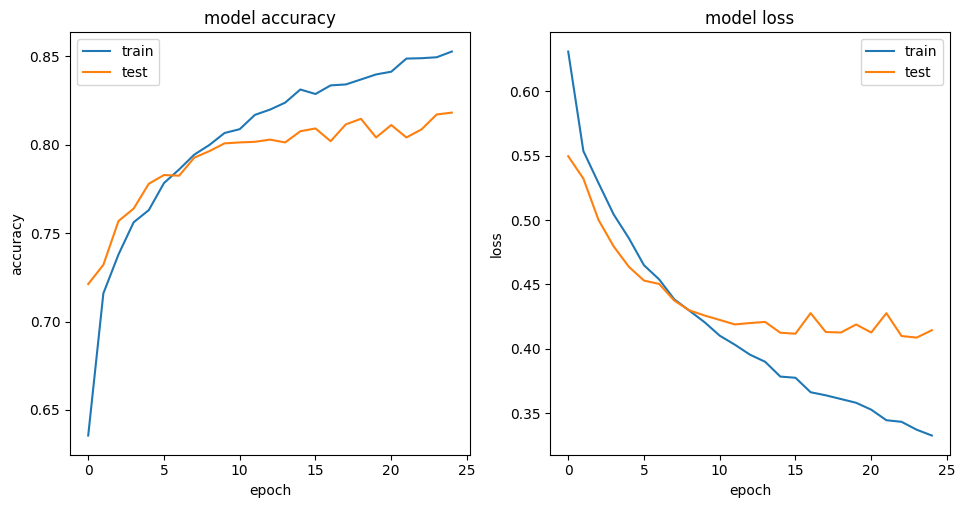

In [0]:
#History.history.keys()
fig,ax = plt.subplots(1,2)
plt.subplots_adjust(bottom = 0,right = 1.5, wspace = 0.2, hspace = 0.7)
plt.subplot(1,2,1)
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(1,2,2)
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');


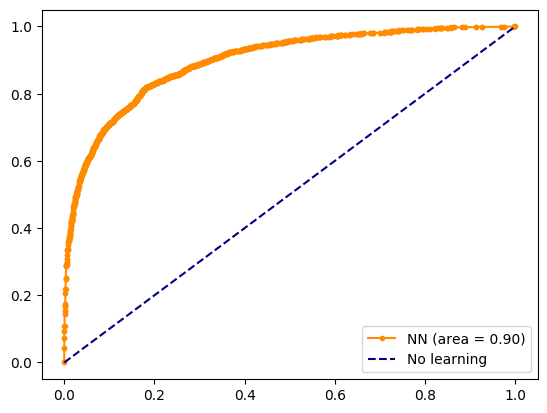

In [0]:
prob_NN = model.predict_proba(X_test_pad)
#probab_NN = prob_NN[:, 1]
fpr_NN, tpr_NN, _ = roc_curve(y_test, prob_NN)
auc_NN = roc_auc_score(y_test, prob_NN)

plt.plot(fpr_NN, tpr_NN, marker='.',color='darkorange', label='%s (area = %0.2f)' % ('NN',auc_NN))
plt.plot([0, 1], [0, 1], linestyle='--',color='navy', label='No learning')
plt.legend(loc="lower right");

In [0]:
from sklearn.metrics import confusion_matrix
pred_nn = model.predict_classes(X_test_pad)

cm = confusion_matrix(y_test,pred_nn )
labels = ['real', 'fake']
print( "CM for NN:\n",cm)
print("Classification Report on Test Set For NN\n",classification_report(y_test, pred_nn,target_names=labels))

CM for NN:
 [[2441  542]
 [ 494 2218]]
Classification Report on Test Set For NN
               precision    recall  f1-score   support

        real       0.83      0.82      0.82      2983
        fake       0.80      0.82      0.81      2712

    accuracy                           0.82      5695
   macro avg       0.82      0.82      0.82      5695
weighted avg       0.82      0.82      0.82      5695



### Save Model in .h5 Format


In [0]:
model.save('/content/drive/My Drive/Fake_news_detect_op/NN_final_model.h5')

# <font color='Blue'>BoW vs Word Emdeddings</font> <br>

1. BoW doesn't takes into account the relationthip of words and hence can't extract contextual information from the textual data. Whereas Word Embeddings clusters similar word in a close vector space and hence can helpful in gathering context from the given text.
2. BoW Approach compartively computationally less expensive than Word Embedding.
3. BoW Approach may work better than Word embeddings if the data size is small and domain specific. 
4. Moreover BoW is good model to quickly build a basic model on textua data and gain some useful insigts about the data along with a baseline working model.


# <Font color="Blue">Conclusion: </font>

In this report two of the famous appraches to Text calssification was discussed. The first one is the BoW approach which either used frequency of words or Term- frequency - Inverse document frequency approach to represent the textual data in numbers. The second approach is to represent the words with the learnned vector in the vectorspce where similar words are clustered (word2vec), which is called word embeddings.

With the given classification task of fake news detection at hand, these two approaches were checked and the analysis found that:

1. MultinomialNB trained on BoW apprach detected fake news comparitively better than SVM and Logistic regression trained using N-fold Grid Search Cross validation model purely based on True positive score. 

2. If we consider overall accuracy, SVM and logistic regression perform equally well which was better than Multinomial Naive Bayes using BoW approach.

3. Pretained Word embeddings can drastically reduce the computational requirement of training a model based on Word embedding approach. 

4. When compared to BoW, Neural network trained using word embedding approach performed poorely for this particular task. This may prove wrong given more computational power and netral network optimization such as adding more neural network layers, etc. 

5. The aboved point hence then suggest that classifiers trained on BoW are computaionally cheap and hence can be used to build a baseine models. Moreover they can perfom better than Word embeddings when available data is small and domain specific( here domain is news). [3]







# References

[1] 	J. Pennington, R. Socher and C. D. Manning, "GloVe: Global Vectors for Word Representation," [Online]. Available: https://nlp.stanford.edu/projects/glove/.<br>

[2] 	Google.com, "Classification: ROC Curve and AUC," [Online]. Available: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc.<br>

[3] 	E. Ma, "3 basic approaches in Bag of Words which are better than Word Embeddings," [Online]. Available: https://towardsdatascience.com/3-basic-approaches-in-bag-of-words-which-are-better-than-word-embeddings-c2cbc7398016.

[4] 	J. Nabi, "Machine Learning — Word Embedding & Sentiment Classification using Keras," [Online]. Available: https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456.
[5] 	Scikit Learn, "API Reference," [Online]. Available: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text.

[6] 	J. Brownlee, "What Are Word Embeddings for Text?," [Online]. Available: https://machinelearningmastery.com/what-are-word-embeddings/.

